In [105]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [106]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [107]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [108]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [109]:
tf.keras.backend.clear_session()

In [110]:
subject = 'São Paulo - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [111]:
data = pd.read_csv('2003_mo_model_input_SP.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),São Paulo - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH
0,2003-1,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,782.111,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723
1,2003-2,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,789.891,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838
2,2003-3,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,774.309,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953
3,2003-4,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,782.071,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068
4,2003-5,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,841.400,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1112.914,1.594636,836.698100,428.210085,13.619906,9.388767,78.021062,1.375399,515.306495,0.590649,NaN,NaN,NaN,NaN,NaN,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1028.144,1.652169,836.016186,424.264417,14.275877,10.374204,79.677117,1.383278,514.812591,0.588569,NaN,NaN,NaN,NaN,NaN,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,996.449,1.732885,835.695882,483.237879,14.605305,10.885898,80.512212,1.400367,514.856452,0.585196,NaN,NaN,NaN,NaN,NaN,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1024.272,1.829429,835.344168,589.245688,14.507213,11.008467,81.524820,1.410545,515.215930,0.581094,NaN,NaN,NaN,NaN,NaN,NaN


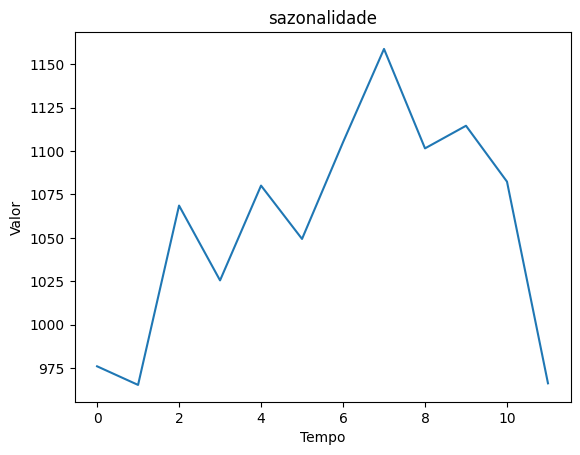

,sazonalidade
sazonalidade,
0,975.978500
1,965.247214
2,1068.600571
3,1025.485071
4,1080.116643
5,1049.376857
6,1105.089462
7,1158.878000
8,1101.569154


In [112]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [113]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,sazonalidade,São Paulo - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723,975.978500,782.111
1,2003-2,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838,965.247214,789.891
2,2003-3,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953,1068.600571,774.309
3,2003-4,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068,1025.485071,782.071
4,2003-5,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183,1080.116643,841.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.594636,836.698100,428.210085,13.619906,9.388767,78.021062,1.375399,515.306495,0.590649,NaN,NaN,NaN,NaN,NaN,NaN,1158.878000,1112.914
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.652169,836.016186,424.264417,14.275877,10.374204,79.677117,1.383278,514.812591,0.588569,NaN,NaN,NaN,NaN,NaN,NaN,1101.569154,1028.144
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.732885,835.695882,483.237879,14.605305,10.885898,80.512212,1.400367,514.856452,0.585196,NaN,NaN,NaN,NaN,NaN,NaN,1114.598000,996.449
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.829429,835.344168,589.245688,14.507213,11.008467,81.524820,1.410545,515.215930,0.581094,NaN,NaN,NaN,NaN,NaN,NaN,1082.392615,1024.272


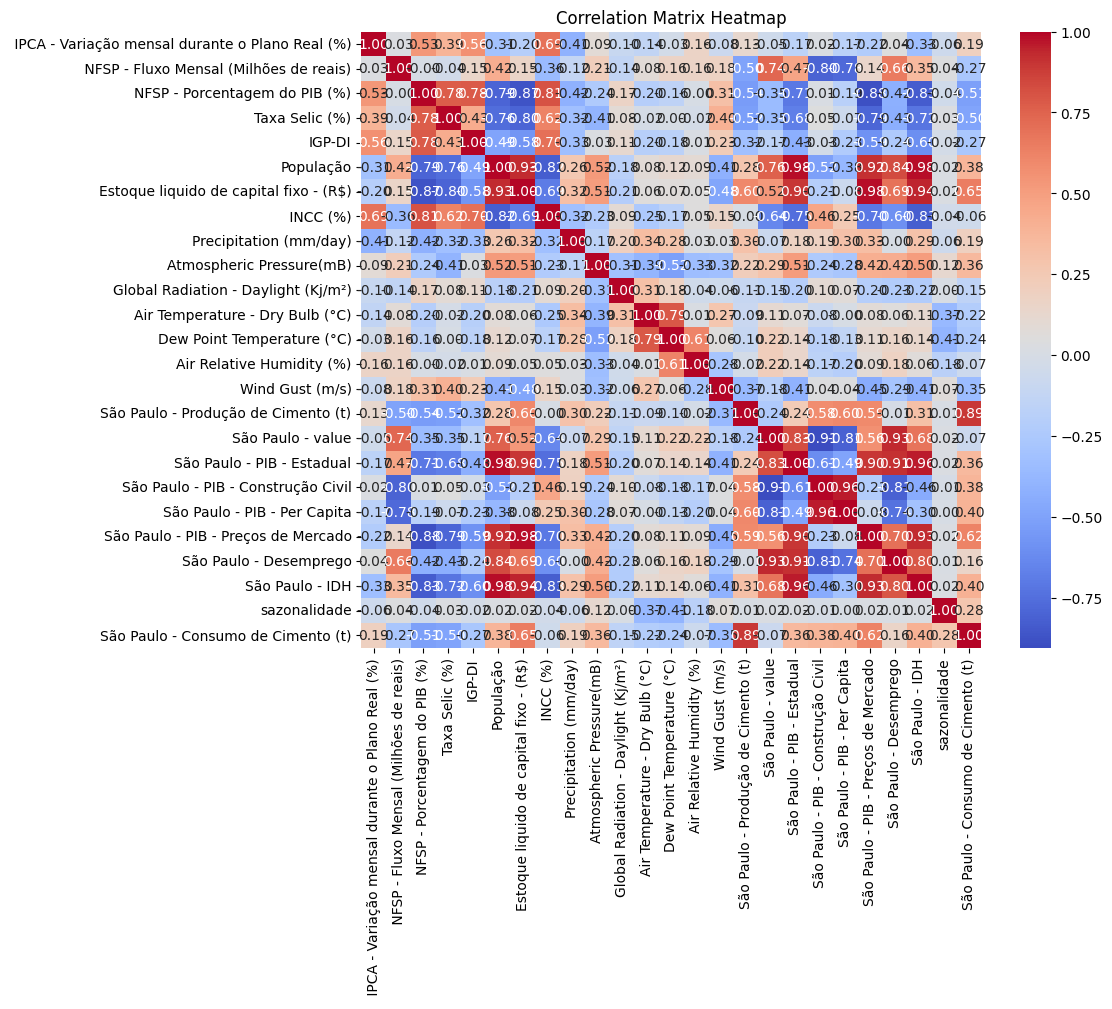

In [114]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [115]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,sazonalidade,São Paulo - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,1.249379,836.486933,11.219632,1.587388,437.972720,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723,975.978500,782.111
1,2003-2,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,1.114976,836.981236,10.140963,1.957841,434.363720,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838,965.247214,789.891
2,2003-3,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,0.946194,837.344257,9.537375,2.068918,433.350868,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953,1068.600571,774.309
3,2003-4,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,0.857395,837.859987,8.663709,2.177406,431.825332,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068,1025.485071,782.071
4,2003-5,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,0.688185,838.094744,7.872689,2.092594,433.287298,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183,1080.116643,841.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.594636,836.698100,9.388767,1.375399,515.306495,0.590649,NaN,NaN,NaN,NaN,NaN,NaN,1158.878000,1112.914
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.652169,836.016186,10.374204,1.383278,514.812591,0.588569,NaN,NaN,NaN,NaN,NaN,NaN,1101.569154,1028.144
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.732885,835.695882,10.885898,1.400367,514.856452,0.585196,NaN,NaN,NaN,NaN,NaN,NaN,1114.598000,996.449
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.829429,835.344168,11.008467,1.410545,515.215930,0.581094,NaN,NaN,NaN,NaN,NaN,NaN,1082.392615,1024.272


In [116]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,sazonalidade
0,2.723741,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,-0.301613,0.142566,-0.236109,-0.124646,-1.410736,-1.192538,-1.718526,-0.426010,-1.485366,-2.737181,-0.804344,-2.274413,-1.357478
1,2.350880,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,-0.761612,0.509729,-0.875121,0.474696,-1.440931,-1.124056,-1.699080,-0.401643,-1.421647,-2.673768,-0.808200,-2.236038,-1.535536
2,2.123016,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-1.339278,0.779377,-1.232691,0.654403,-1.449405,-1.050974,-1.679635,-0.377275,-1.357928,-2.610355,-0.812056,-2.197662,0.179351
3,2.021477,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-1.643200,1.162456,-1.750257,0.829923,-1.462169,-0.985091,-1.660189,-0.352908,-1.294210,-2.546942,-0.815911,-2.159286,-0.536042
4,1.887113,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-2.222331,1.336831,-2.218863,0.692708,-1.449937,-0.920633,-1.640744,-0.328540,-1.230491,-2.483529,-0.819767,-2.120910,0.370431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-2.010387,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-0.148786,0.477721,-0.294274,0.686271,-1.209684,1.711139,1.107674,-1.587758,-1.453963,0.436685,1.040670,0.784878,1.677275
188,-1.870713,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,0.576252,0.081167,0.308974,1.459488,-1.192369,1.711746,1.098119,-1.580975,-1.459558,0.423023,1.034370,0.748669,0.726380
189,-1.806230,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,0.719922,0.115490,0.911081,2.084401,-1.178463,1.717654,1.088565,-1.574192,-1.465154,0.409361,1.028069,0.712461,0.942561
190,-1.727496,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,1.456172,0.025600,1.255847,2.228054,-1.166182,1.729082,1.079010,-1.567409,-1.470749,0.395699,1.021769,0.676253,0.408195


In [117]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      706.731
1      697.361
2      859.304
3      762.222
4      763.920
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: São Paulo - Consumo de Cimento (t), Length: 240, dtype: float64

In [118]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,sazonalidade
0,2.723741,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,-0.301613,0.142566,-0.236109,-0.124646,-1.410736,-1.192538,-1.718526,-0.426010,-1.485366,-2.737181,-0.804344,-2.274413,-1.357478
1,2.350880,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,-0.761612,0.509729,-0.875121,0.474696,-1.440931,-1.124056,-1.699080,-0.401643,-1.421647,-2.673768,-0.808200,-2.236038,-1.535536
2,2.123016,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-1.339278,0.779377,-1.232691,0.654403,-1.449405,-1.050974,-1.679635,-0.377275,-1.357928,-2.610355,-0.812056,-2.197662,0.179351
3,2.021477,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-1.643200,1.162456,-1.750257,0.829923,-1.462169,-0.985091,-1.660189,-0.352908,-1.294210,-2.546942,-0.815911,-2.159286,-0.536042
4,1.887113,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-2.222331,1.336831,-2.218863,0.692708,-1.449937,-0.920633,-1.640744,-0.328540,-1.230491,-2.483529,-0.819767,-2.120910,0.370431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-0.214006,1.216560,-0.607704,0.043807,-1.233012,1.031384,0.819304,-0.883659,0.722011,0.549267,1.840143,0.236066,-0.608419,1.023937,1.193677,-1.393041,-1.206846,0.733610,1.413038,1.566441,-1.535536
158,-0.434717,1.155373,-0.620523,0.210856,-1.299304,1.042716,0.808136,-0.950771,0.664991,0.839118,1.168034,0.025668,-0.653197,1.033712,1.195577,-1.411276,-1.217300,0.727991,1.392752,1.539489,0.179351
159,-0.524091,1.056140,-0.631530,0.107070,-1.248662,1.054049,0.796969,-1.028465,-0.285297,1.070539,0.270107,-0.140782,-0.699576,1.049101,1.197477,-1.429511,-1.227755,0.722372,1.372465,1.512536,-0.536042
160,-0.614500,1.147619,-0.640320,0.392942,-1.068274,1.065381,0.785801,-1.103668,-0.404072,1.228328,-0.416655,-0.235046,-0.757794,1.059564,1.199378,-1.447746,-1.238210,0.716753,1.352178,1.485583,0.370431


In [119]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      706.731
1      697.361
2      859.304
3      762.222
4      763.920
        ...   
157    757.915
158    923.634
159    756.663
160    872.715
161    844.988
Name: São Paulo - Consumo de Cimento (t), Length: 162, dtype: float64

In [120]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [121]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 21)

In [122]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,sazonalidade
126,0.888984,-0.230612,-0.460555,-1.048761,-0.368821,0.651397,0.944085,0.045243,-0.896568,0.887074,-1.113982,-0.838235,1.357021,0.718372,0.835331,-0.070173,-0.126212,1.060884,0.965416,0.617332,0.784791
127,0.954254,-0.156322,-0.440372,-0.649312,-0.328087,0.664707,0.947319,0.061828,-0.910642,0.540011,-0.841739,-0.864011,1.320237,0.803494,0.853864,-0.120590,-0.162580,1.058281,0.995407,0.624883,1.677275
128,1.045217,-0.120008,-0.419247,-0.535369,-0.176031,0.678017,0.950553,0.046225,-0.165312,-0.008751,-0.238470,-0.879773,1.259517,0.892135,0.872396,-0.171007,-0.198948,1.055678,1.025397,0.632435,0.726380
129,1.176395,-0.143194,-0.397019,-1.288807,-0.113037,0.691327,0.953786,0.032522,0.385882,-0.195358,0.232682,-0.890673,1.196227,0.945408,0.890929,-0.221425,-0.235316,1.053074,1.055388,0.639987,0.942561
130,1.303259,-0.028712,-0.376532,-1.507550,-0.022703,0.704637,0.957020,0.042757,0.676604,-0.325096,0.589739,-0.898164,1.135312,0.989786,0.909462,-0.271842,-0.271684,1.050471,1.085379,0.647538,0.408195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-2.010387,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-0.148786,0.477721,-0.294274,0.686271,-1.209684,1.711139,1.107674,-1.587758,-1.453963,0.436685,1.040670,0.784878,1.677275
188,-1.870713,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,0.576252,0.081167,0.308974,1.459488,-1.192369,1.711746,1.098119,-1.580975,-1.459558,0.423023,1.034370,0.748669,0.726380
189,-1.806230,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,0.719922,0.115490,0.911081,2.084401,-1.178463,1.717654,1.088565,-1.574192,-1.465154,0.409361,1.028069,0.712461,0.942561
190,-1.727496,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,1.456172,0.025600,1.255847,2.228054,-1.166182,1.729082,1.079010,-1.567409,-1.470749,0.395699,1.021769,0.676253,0.408195


In [123]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 21)

In [124]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [125]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 6)
    target,target_val = validation_splitter(train_target, 6)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [126]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [127]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1492700984, 481608123, 3406539017, 1251660928, 3136986756, 2564588930, 2985235614, 2296360932, 3482039479, 1296102957]


Step: 0 ___________________________________________
val_loss: 18599.3515625
winner_seed: 1492700984


Step: 1 ___________________________________________
val_loss: 18243.330078125
winner_seed: 481608123


Step: 2 ___________________________________________
val_loss: 6070.47705078125
winner_seed: 3406539017


Step: 3 ___________________________________________
val_loss: 18187.93359375


Step: 4 ___________________________________________
val_loss: 12510.962890625


Step: 5 ___________________________________________
val_loss: 4459.59716796875
winner_seed: 2564588930


Step: 6 ___________________________________________
val_loss: 18599.369140625


Step: 7 ___________________________________________
val_loss: 18115.5859375


Step: 8 ___________________________________________
val_loss: 6404.46728515625


Step: 9 ___________________________________________
val_loss: 185

In [128]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 114ms/step - loss: 951847.6875 - val_loss: 19700.6035
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 26432.8164 - val_loss: 38170.7734
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 28550.1484 - val_loss: 38026.1484
Epoch 4/10000
4/4 [==============================] - 0s 8ms/step - loss: 32595.1953 - val_loss: 38804.6914
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 27706.0195 - val_loss: 23321.2969
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 27171.8730 - val_loss: 33262.0820
Epoch 7/10000
4/4 [==============================] - 0s 8ms/step - loss: 26738.3047 - val_loss: 22405.5000
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 25246.4980 - val_loss: 22126.0801
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 25557.5938 - val_loss: 18452.6191
Epoch 10/10000
4/4 [==============

Epoch 77/10000
4/4 [==============================] - 0s 9ms/step - loss: 25868.7949 - val_loss: 41620.1133
Epoch 78/10000
4/4 [==============================] - 0s 11ms/step - loss: 28062.5391 - val_loss: 20577.5273
Epoch 79/10000
4/4 [==============================] - 0s 10ms/step - loss: 24952.8496 - val_loss: 27969.0840
Epoch 80/10000
4/4 [==============================] - 0s 9ms/step - loss: 25006.1328 - val_loss: 18391.1777
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 26432.0898 - val_loss: 21939.9277
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 24959.2598 - val_loss: 22289.8281
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 25067.6152 - val_loss: 36898.2148
Epoch 84/10000
4/4 [==============================] - 0s 8ms/step - loss: 26563.8164 - val_loss: 29521.7559
Epoch 85/10000
4/4 [==============================] - 0s 8ms/step - loss: 25227.2363 - val_loss: 28802.8594
Epoch 86/10000
4/4 [======

4/4 [==============================] - 0s 8ms/step - loss: 26699.1816 - val_loss: 18692.6914
Epoch 153/10000
4/4 [==============================] - 0s 9ms/step - loss: 25733.8164 - val_loss: 24968.5898
Epoch 154/10000
4/4 [==============================] - 0s 9ms/step - loss: 24877.1074 - val_loss: 22586.6914
Epoch 155/10000
4/4 [==============================] - 0s 9ms/step - loss: 24932.9238 - val_loss: 35029.1289
Epoch 156/10000
4/4 [==============================] - 0s 9ms/step - loss: 25679.7891 - val_loss: 18943.8242
Epoch 157/10000
4/4 [==============================] - 0s 8ms/step - loss: 25439.2246 - val_loss: 19110.4023
Epoch 158/10000
4/4 [==============================] - 0s 9ms/step - loss: 27363.9277 - val_loss: 31971.2617
Epoch 159/10000
4/4 [==============================] - 0s 10ms/step - loss: 27036.7383 - val_loss: 26720.3516
Epoch 160/10000
4/4 [==============================] - 0s 9ms/step - loss: 26831.0762 - val_loss: 26255.5664
Epoch 161/10000
4/4 [=============

4/4 [==============================] - 0s 9ms/step - loss: 25350.4688 - val_loss: 18895.1914
Epoch 228/10000
4/4 [==============================] - 0s 9ms/step - loss: 28790.0957 - val_loss: 19976.5488
Epoch 229/10000
4/4 [==============================] - 0s 9ms/step - loss: 25177.8164 - val_loss: 29963.3750
Epoch 230/10000
4/4 [==============================] - 0s 11ms/step - loss: 25796.3398 - val_loss: 18620.6191
Epoch 231/10000
4/4 [==============================] - 0s 10ms/step - loss: 26616.1406 - val_loss: 26012.0215
Epoch 232/10000
4/4 [==============================] - 0s 10ms/step - loss: 26068.9434 - val_loss: 28227.7676
Epoch 233/10000
4/4 [==============================] - 0s 10ms/step - loss: 26119.3340 - val_loss: 22027.7012
Epoch 234/10000
4/4 [==============================] - 0s 9ms/step - loss: 25750.0098 - val_loss: 21722.9844
Epoch 235/10000
4/4 [==============================] - 0s 10ms/step - loss: 25454.1387 - val_loss: 23724.7051
Epoch 236/10000
4/4 [=========

4/4 [==============================] - 0s 9ms/step - loss: 25436.4102 - val_loss: 24366.5430
Epoch 303/10000
4/4 [==============================] - 0s 8ms/step - loss: 25973.8691 - val_loss: 43264.9922
Epoch 304/10000
4/4 [==============================] - 0s 8ms/step - loss: 27337.2754 - val_loss: 19555.4473
Epoch 305/10000
4/4 [==============================] - 0s 8ms/step - loss: 26091.1621 - val_loss: 23423.6660
Epoch 306/10000
4/4 [==============================] - 0s 9ms/step - loss: 25930.0742 - val_loss: 19401.5566
Epoch 307/10000
4/4 [==============================] - 0s 8ms/step - loss: 25554.5957 - val_loss: 21468.7578
Epoch 308/10000
4/4 [==============================] - 0s 8ms/step - loss: 27006.1328 - val_loss: 19078.2832
Epoch 309/10000
4/4 [==============================] - 0s 9ms/step - loss: 31293.0996 - val_loss: 24394.5039
Epoch 310/10000
4/4 [==============================] - 0s 8ms/step - loss: 26122.9102 - val_loss: 26187.4023
Epoch 311/10000
4/4 [==============

4/4 [==============================] - 0s 9ms/step - loss: 25651.1934 - val_loss: 34938.3438
Epoch 378/10000
4/4 [==============================] - 0s 9ms/step - loss: 27981.5098 - val_loss: 22774.0293
Epoch 379/10000
4/4 [==============================] - 0s 9ms/step - loss: 25201.4258 - val_loss: 24703.0117
Epoch 380/10000
4/4 [==============================] - 0s 9ms/step - loss: 26373.9141 - val_loss: 23812.2715
Epoch 381/10000
4/4 [==============================] - 0s 10ms/step - loss: 26070.4355 - val_loss: 20671.2109
Epoch 382/10000
4/4 [==============================] - 0s 9ms/step - loss: 27609.7480 - val_loss: 25769.7832
Epoch 383/10000
4/4 [==============================] - 0s 9ms/step - loss: 25579.2500 - val_loss: 31096.9590
Epoch 384/10000
4/4 [==============================] - 0s 9ms/step - loss: 26295.3008 - val_loss: 24180.5078
Epoch 385/10000
4/4 [==============================] - 0s 9ms/step - loss: 25785.5898 - val_loss: 19685.2070
Epoch 386/10000
4/4 [=============

4/4 [==============================] - 0s 9ms/step - loss: 10431.0273 - val_loss: 16415.5039
Epoch 453/10000
4/4 [==============================] - 0s 8ms/step - loss: 8234.2266 - val_loss: 11427.1953
Epoch 454/10000
4/4 [==============================] - 0s 8ms/step - loss: 8310.4150 - val_loss: 9513.8311
Epoch 455/10000
4/4 [==============================] - 0s 8ms/step - loss: 8404.9287 - val_loss: 14955.6699
Epoch 456/10000
4/4 [==============================] - 0s 9ms/step - loss: 10436.3154 - val_loss: 8704.2295
Epoch 457/10000
4/4 [==============================] - 0s 9ms/step - loss: 8780.5264 - val_loss: 11613.9941
Epoch 458/10000
4/4 [==============================] - 0s 9ms/step - loss: 8628.1357 - val_loss: 20258.7148
Epoch 459/10000
4/4 [==============================] - 0s 9ms/step - loss: 51110.0781 - val_loss: 47777.1328
Epoch 460/10000
4/4 [==============================] - 0s 8ms/step - loss: 25239.0762 - val_loss: 17890.8184
Epoch 461/10000
4/4 [=====================

Epoch 528/10000
4/4 [==============================] - 0s 8ms/step - loss: 6228.0020 - val_loss: 11363.9307
Epoch 529/10000
4/4 [==============================] - 0s 7ms/step - loss: 5819.7148 - val_loss: 14709.8076
Epoch 530/10000
4/4 [==============================] - 0s 7ms/step - loss: 5341.0215 - val_loss: 14849.1924
Epoch 531/10000
4/4 [==============================] - 0s 7ms/step - loss: 6077.5879 - val_loss: 17920.4082
Epoch 532/10000
4/4 [==============================] - 0s 7ms/step - loss: 5144.9614 - val_loss: 13992.0508
Epoch 533/10000
4/4 [==============================] - 0s 7ms/step - loss: 6288.9370 - val_loss: 11021.5400
Epoch 534/10000
4/4 [==============================] - 0s 7ms/step - loss: 5425.0142 - val_loss: 10920.3535
Epoch 535/10000
4/4 [==============================] - 0s 8ms/step - loss: 5678.9180 - val_loss: 8287.7656
Epoch 536/10000
4/4 [==============================] - 0s 7ms/step - loss: 6022.5288 - val_loss: 8616.3320
Epoch 537/10000
4/4 [=========

4/4 [==============================] - 0s 8ms/step - loss: 5588.0103 - val_loss: 7329.4189
Epoch 605/10000
4/4 [==============================] - 0s 9ms/step - loss: 5339.1963 - val_loss: 10210.1543
Epoch 606/10000
4/4 [==============================] - 0s 8ms/step - loss: 4966.0146 - val_loss: 8831.0596
Epoch 607/10000
4/4 [==============================] - 0s 9ms/step - loss: 4683.2007 - val_loss: 8881.3232
Epoch 608/10000
4/4 [==============================] - 0s 8ms/step - loss: 5640.8022 - val_loss: 10030.2852
Epoch 609/10000
4/4 [==============================] - 0s 9ms/step - loss: 6398.9155 - val_loss: 6960.2354
Epoch 610/10000
4/4 [==============================] - 0s 9ms/step - loss: 6690.4644 - val_loss: 12909.7012
Epoch 611/10000
4/4 [==============================] - 0s 9ms/step - loss: 4907.0039 - val_loss: 10950.0566
Epoch 612/10000
4/4 [==============================] - 0s 9ms/step - loss: 5369.2725 - val_loss: 7955.0669
Epoch 613/10000
4/4 [============================

4/4 [==============================] - 0s 10ms/step - loss: 5632.4048 - val_loss: 11938.2861
Epoch 681/10000
4/4 [==============================] - 0s 9ms/step - loss: 5526.1279 - val_loss: 8428.8926
Epoch 682/10000
4/4 [==============================] - 0s 9ms/step - loss: 4858.0615 - val_loss: 8581.1133
Epoch 683/10000
4/4 [==============================] - 0s 9ms/step - loss: 4922.9731 - val_loss: 10536.3887
Epoch 684/10000
4/4 [==============================] - 0s 9ms/step - loss: 5753.7573 - val_loss: 6166.9492
Epoch 685/10000
4/4 [==============================] - 0s 9ms/step - loss: 4640.0322 - val_loss: 6089.1104
Epoch 686/10000
4/4 [==============================] - 0s 8ms/step - loss: 4393.9629 - val_loss: 6895.0444
Epoch 687/10000
4/4 [==============================] - 0s 8ms/step - loss: 4645.2891 - val_loss: 8012.5654
Epoch 688/10000
4/4 [==============================] - 0s 9ms/step - loss: 4666.6362 - val_loss: 7967.3135
Epoch 689/10000
4/4 [=============================

4/4 [==============================] - 0s 9ms/step - loss: 5047.1895 - val_loss: 7420.7456
Epoch 757/10000
4/4 [==============================] - 0s 9ms/step - loss: 4433.7334 - val_loss: 6190.8540
Epoch 758/10000
4/4 [==============================] - 0s 9ms/step - loss: 5085.0356 - val_loss: 4974.7124
Epoch 759/10000
4/4 [==============================] - 0s 9ms/step - loss: 4898.6592 - val_loss: 6834.2397
Epoch 760/10000
4/4 [==============================] - 0s 9ms/step - loss: 5030.6582 - val_loss: 6151.6382
Epoch 761/10000
4/4 [==============================] - 0s 9ms/step - loss: 4442.6279 - val_loss: 7837.0356
Epoch 762/10000
4/4 [==============================] - 0s 10ms/step - loss: 4372.9907 - val_loss: 6145.2554
Epoch 763/10000
4/4 [==============================] - 0s 9ms/step - loss: 3840.4507 - val_loss: 7726.6743
Epoch 764/10000
4/4 [==============================] - 0s 10ms/step - loss: 4554.4897 - val_loss: 11684.4512
Epoch 765/10000
4/4 [=============================

4/4 [==============================] - 0s 9ms/step - loss: 4896.8296 - val_loss: 6754.8257
Epoch 833/10000
4/4 [==============================] - 0s 9ms/step - loss: 4820.7358 - val_loss: 7141.8154
Epoch 834/10000
4/4 [==============================] - 0s 9ms/step - loss: 4405.3774 - val_loss: 6632.7041
Epoch 835/10000
4/4 [==============================] - 0s 9ms/step - loss: 4273.4209 - val_loss: 9413.2295
Epoch 836/10000
4/4 [==============================] - 0s 9ms/step - loss: 5155.5562 - val_loss: 8816.1299
Epoch 837/10000
4/4 [==============================] - 0s 9ms/step - loss: 5676.2544 - val_loss: 7647.4644
Epoch 838/10000
4/4 [==============================] - 0s 9ms/step - loss: 5002.3867 - val_loss: 7205.6860
Epoch 839/10000
4/4 [==============================] - 0s 9ms/step - loss: 5580.9150 - val_loss: 7120.6680
Epoch 840/10000
4/4 [==============================] - 0s 10ms/step - loss: 4515.4644 - val_loss: 7837.5083
Epoch 841/10000
4/4 [==============================]

4/4 [==============================] - 0s 9ms/step - loss: 5081.5371 - val_loss: 7428.6704
Epoch 909/10000
4/4 [==============================] - 0s 9ms/step - loss: 5867.3433 - val_loss: 5835.1006
Epoch 910/10000
4/4 [==============================] - 0s 8ms/step - loss: 7475.7153 - val_loss: 8122.7334
Epoch 911/10000
4/4 [==============================] - 0s 8ms/step - loss: 4823.0566 - val_loss: 9330.8779
Epoch 912/10000
4/4 [==============================] - 0s 8ms/step - loss: 5589.2656 - val_loss: 5832.4038
Epoch 913/10000
4/4 [==============================] - 0s 9ms/step - loss: 6279.8428 - val_loss: 6068.6909
Epoch 914/10000
4/4 [==============================] - 0s 8ms/step - loss: 4767.5757 - val_loss: 5801.3242
Epoch 915/10000
4/4 [==============================] - 0s 9ms/step - loss: 5502.0518 - val_loss: 6253.6133
Epoch 916/10000
4/4 [==============================] - 0s 9ms/step - loss: 5277.4453 - val_loss: 6669.2007
Epoch 917/10000
4/4 [==============================] 

4/4 [==============================] - 0s 9ms/step - loss: 4383.5469 - val_loss: 6211.8691
Epoch 985/10000
4/4 [==============================] - 0s 9ms/step - loss: 4946.0220 - val_loss: 5872.0391
Epoch 986/10000
4/4 [==============================] - 0s 9ms/step - loss: 5608.2979 - val_loss: 5260.0781
Epoch 987/10000
4/4 [==============================] - 0s 8ms/step - loss: 5731.7178 - val_loss: 6906.8809
Epoch 988/10000
4/4 [==============================] - 0s 9ms/step - loss: 5739.8213 - val_loss: 6141.7900
Epoch 989/10000
4/4 [==============================] - 0s 9ms/step - loss: 5380.8975 - val_loss: 5537.6509
Epoch 990/10000
4/4 [==============================] - 0s 9ms/step - loss: 4395.2339 - val_loss: 6324.1279
Epoch 991/10000
4/4 [==============================] - 0s 9ms/step - loss: 3914.6235 - val_loss: 7594.5825
Epoch 992/10000
4/4 [==============================] - 0s 10ms/step - loss: 4405.7261 - val_loss: 4696.6694
Epoch 993/10000
4/4 [==============================]

4/4 [==============================] - 0s 8ms/step - loss: 6296.2061 - val_loss: 11754.9355
Epoch 1061/10000
4/4 [==============================] - 0s 9ms/step - loss: 5798.0210 - val_loss: 8523.4766
Epoch 1062/10000
4/4 [==============================] - 0s 8ms/step - loss: 4453.4756 - val_loss: 7140.1250
Epoch 1063/10000
4/4 [==============================] - 0s 9ms/step - loss: 6564.4507 - val_loss: 8091.8804
Epoch 1064/10000
4/4 [==============================] - 0s 8ms/step - loss: 6813.5288 - val_loss: 7413.2002
Epoch 1065/10000
4/4 [==============================] - 0s 8ms/step - loss: 5545.6470 - val_loss: 7840.1719
Epoch 1066/10000
4/4 [==============================] - 0s 9ms/step - loss: 5727.5513 - val_loss: 9680.6787
Epoch 1067/10000
4/4 [==============================] - 0s 9ms/step - loss: 5273.5117 - val_loss: 5913.0166
Epoch 1068/10000
4/4 [==============================] - 0s 9ms/step - loss: 4867.4517 - val_loss: 9437.6016
Epoch 1069/10000
4/4 [======================

4/4 [==============================] - 0s 9ms/step - loss: 5856.1191 - val_loss: 11818.1133
Epoch 1136/10000
4/4 [==============================] - 0s 10ms/step - loss: 5717.4160 - val_loss: 16893.4473
Epoch 1137/10000
4/4 [==============================] - 0s 9ms/step - loss: 5649.3091 - val_loss: 17398.0684
Epoch 1138/10000
4/4 [==============================] - 0s 9ms/step - loss: 4255.3535 - val_loss: 18397.5566
Epoch 1139/10000
4/4 [==============================] - 0s 8ms/step - loss: 5937.9438 - val_loss: 12431.4453
Epoch 1140/10000
4/4 [==============================] - 0s 8ms/step - loss: 5678.2319 - val_loss: 15531.8926
Epoch 1141/10000
4/4 [==============================] - 0s 8ms/step - loss: 5638.7192 - val_loss: 14246.3076
Epoch 1142/10000
4/4 [==============================] - 0s 8ms/step - loss: 5134.6382 - val_loss: 13462.0342
Epoch 1143/10000
4/4 [==============================] - 0s 8ms/step - loss: 5315.2612 - val_loss: 10889.3232
Epoch 1144/10000
4/4 [=============

4/4 [==============================] - 0s 9ms/step - loss: 5601.3994 - val_loss: 15027.4824
Epoch 1211/10000
4/4 [==============================] - 0s 9ms/step - loss: 5453.6621 - val_loss: 12680.2109
Epoch 1212/10000
4/4 [==============================] - 0s 9ms/step - loss: 6003.6826 - val_loss: 14594.3721
Epoch 1213/10000
4/4 [==============================] - 0s 10ms/step - loss: 5013.3062 - val_loss: 10390.6484
Epoch 1214/10000
4/4 [==============================] - 0s 10ms/step - loss: 5399.0430 - val_loss: 15497.2188
Epoch 1215/10000
4/4 [==============================] - 0s 10ms/step - loss: 4684.2578 - val_loss: 13665.7520
Epoch 1216/10000
4/4 [==============================] - 0s 10ms/step - loss: 5256.0181 - val_loss: 12639.6143
Epoch 1217/10000
4/4 [==============================] - 0s 9ms/step - loss: 6252.1885 - val_loss: 14227.3145
Epoch 1218/10000
4/4 [==============================] - 0s 8ms/step - loss: 5538.0083 - val_loss: 14238.5195
Epoch 1219/10000
4/4 [==========

4/4 [==============================] - 0s 9ms/step - loss: 5028.4102 - val_loss: 11372.4707
Epoch 1286/10000
4/4 [==============================] - 0s 10ms/step - loss: 5022.8325 - val_loss: 10668.4395
Epoch 1287/10000
4/4 [==============================] - 0s 9ms/step - loss: 4279.8965 - val_loss: 11573.6592
Epoch 1288/10000
4/4 [==============================] - 0s 9ms/step - loss: 5047.2671 - val_loss: 12303.5479
Epoch 1289/10000
4/4 [==============================] - 0s 8ms/step - loss: 6036.2954 - val_loss: 10200.1709
Epoch 1290/10000
4/4 [==============================] - 0s 8ms/step - loss: 4962.2739 - val_loss: 12010.5479
Epoch 1291/10000
4/4 [==============================] - 0s 9ms/step - loss: 4144.3428 - val_loss: 12632.4941
Epoch 1292/10000
4/4 [==============================] - 0s 9ms/step - loss: 4302.6182 - val_loss: 10809.2305
Epoch 1293/10000
4/4 [==============================] - 0s 8ms/step - loss: 5310.1489 - val_loss: 16578.9961
Epoch 1294/10000
4/4 [=============

4/4 [==============================] - 0s 8ms/step - loss: 4504.3442 - val_loss: 14010.1279
Epoch 1361/10000
4/4 [==============================] - 0s 8ms/step - loss: 4970.0898 - val_loss: 13803.0088
Epoch 1362/10000
4/4 [==============================] - 0s 8ms/step - loss: 5381.8516 - val_loss: 8612.8457
Epoch 1363/10000
4/4 [==============================] - 0s 8ms/step - loss: 4601.0840 - val_loss: 10241.7490
Epoch 1364/10000
4/4 [==============================] - 0s 8ms/step - loss: 5223.8433 - val_loss: 11632.7500
Epoch 1365/10000
4/4 [==============================] - 0s 8ms/step - loss: 5521.9453 - val_loss: 12822.9854
Epoch 1366/10000
4/4 [==============================] - 0s 9ms/step - loss: 5363.4077 - val_loss: 15551.0195
Epoch 1367/10000
4/4 [==============================] - 0s 9ms/step - loss: 5116.2339 - val_loss: 15700.6162
Epoch 1368/10000
4/4 [==============================] - 0s 9ms/step - loss: 5596.6191 - val_loss: 13295.7764
Epoch 1369/10000
4/4 [===============

4/4 [==============================] - 0s 9ms/step - loss: 5934.8252 - val_loss: 10796.3389
Epoch 1436/10000
4/4 [==============================] - 0s 9ms/step - loss: 5601.2773 - val_loss: 9928.2334
Epoch 1437/10000
4/4 [==============================] - 0s 9ms/step - loss: 6141.1123 - val_loss: 9574.8379
Epoch 1438/10000
4/4 [==============================] - 0s 9ms/step - loss: 7473.1108 - val_loss: 11877.1230
Epoch 1439/10000
4/4 [==============================] - 0s 9ms/step - loss: 5853.4863 - val_loss: 12983.4424
Epoch 1440/10000
4/4 [==============================] - 0s 9ms/step - loss: 5478.4238 - val_loss: 12273.8545
Epoch 1441/10000
4/4 [==============================] - 0s 9ms/step - loss: 5968.9321 - val_loss: 15429.2080
Epoch 1442/10000
4/4 [==============================] - 0s 9ms/step - loss: 7097.0400 - val_loss: 11098.2754
Epoch 1443/10000
4/4 [==============================] - 0s 9ms/step - loss: 6676.6567 - val_loss: 11407.5908
Epoch 1444/10000
4/4 [================

In [129]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [130]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,817.390381,817.167358,815.63092,816.639893,815.613403,822.735596,821.708923,819.436768,812.598022,815.757019,809.06604,796.634155,797.16394,806.298096,806.845215,815.009949,811.602173,817.807983,815.373535,818.513306,814.022766,815.07251,815.522095,814.081665,816.10376,817.035522,813.369934,816.993286,815.067444,909.853943
Target,910.653,937.696,871.611,795.853,804.767,712.733,763.665,727.397,855.245,855.042,648.867,1003.807,855.104,913.329,849.262,897.883,860.059,771.417,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,93.262634,120.528625,55.980103,20.786865,10.846375,110.002625,58.043945,92.039795,42.646973,39.284973,160.199036,207.172852,57.940063,107.030884,42.416809,82.873047,48.456848,46.390991,44.858459,44.906311,23.87677,71.856506,126.077881,3.21936,141.185242,161.954468,93.58606,163.954712,56.978577,217.621948


In [131]:
display(mae)
display(mape)

84.866

0.100221045

In [132]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [133]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[9780.378]] - Target[9887.336000000001]| =  Error: [[106.95801]]; MAPE:[[0.01081768]]
1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[9747.314]] - Target[10216.868999999999]| =  Error: [[469.5547]]; MAPE:[[0.04595876]]
1/1 [==============================] - 0s 14ms/step
Ano-5: |Prediction[[4988.424]] - Target[5388.461]| =  Error: [[400.0371]]; MAPE:[[0.07423959]]


[array([[106.95801]], dtype=float32),
 array([[469.5547]], dtype=float32),
 array([[400.0371]], dtype=float32)]

325.5166

0.04367201